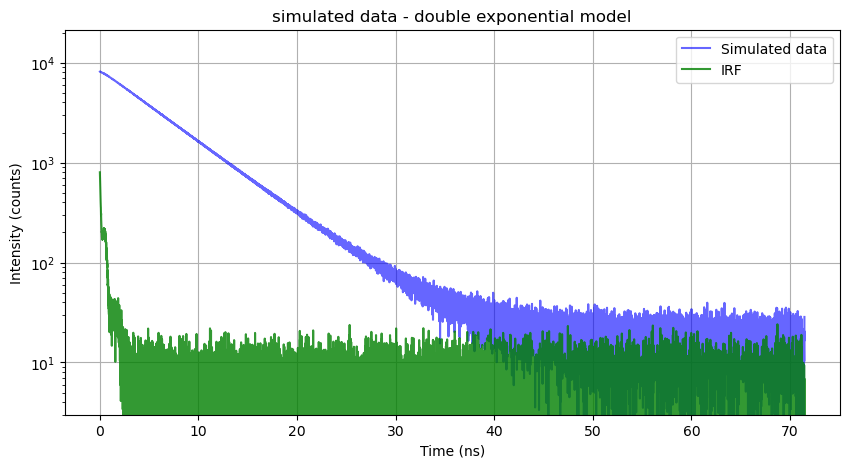

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import least_squares


t = np.linspace(0, 0.004*20000, 20001)
delta_t = 0.004
n_values = np.arange(11)
gauss_params = [5000, 0.25, 8e+00, 100, 0.2, 9, 50, 0.65, 10, 1.5e+00]
model_params = [0.0072, 6]


def skewed_IRF_with_small_peak(t, A1, sigma1, mu1, A2, sigma2, mu2, A3, sigma3, mu3, b):
    # Main Gaussian peak
    main_peak = A1 / (sigma1 * np.sqrt(2 * np.pi)) * np.exp(-((t - mu1)**2) / (2 * sigma1**2))
    
    # Smaller Gaussian peak to the right-hand side
    small_peak = A2 / (sigma2 * np.sqrt(2 * np.pi)) * np.exp(-((t - mu2)**2) / (2 * sigma2**2))

    smaller_peak =  A3 / (sigma3 * np.sqrt(2 * np.pi)) * np.exp(-((t - mu3)**2) / (2 * sigma3**2))
    
    # Combine the main peak, the small peak, and the baseline offset
    irf = main_peak + small_peak +smaller_peak + b

    return irf

def skewed_IRF_with_small_peak_noise (t, A1, sigma1, mu1, A2, sigma2, mu2, A3, sigma3, mu3, b):
    # Main Gaussian peak
    main_peak = A1 / (sigma1 * np.sqrt(2 * np.pi)) * np.exp(-((t - mu1)**2) / (2 * sigma1**2))
    
    # Smaller Gaussian peak to the right-hand side
    small_peak = A2 / (sigma2 * np.sqrt(2 * np.pi)) * np.exp(-((t - mu2)**2) / (2 * sigma2**2))

    smaller_peak =  A3 / (sigma3 * np.sqrt(2 * np.pi)) * np.exp(-((t - mu3)**2) / (2 * sigma3**2))
    
    # Combine the main peak, the small peak, and the baseline offset
    irf = main_peak + small_peak +smaller_peak + b
    noise_level = 0.0008 * max(irf)
    noise = np.random.normal(loc=0, scale=noise_level, size=irf.shape)
    return np.clip(irf + noise, a_min=0, a_max=None)

IRF_noisy = skewed_IRF_with_small_peak_noise(t, *gauss_params)
IRF_no_noise = skewed_IRF_with_small_peak(t, *gauss_params)

def single_exp_model_truncated(t, a, tau):
    model = a * np.exp(-t / tau)
    # Perform convolution of the model with the input response function (irf)
    raw_convolution = scipy.signal.fftconvolve(model, IRF_no_noise, mode='full')[:len(t)]
    # Calculate noise level as a percentage of the maximum point of the raw convolution
    noise_level = 0.0008 * max(raw_convolution)
    # Generate random noise
    noise = np.random.normal(loc=0, scale=noise_level, size=raw_convolution.shape)
    # Add noise to the raw convolution
    noisy_convolution = raw_convolution + noise
    max_idx = np.argmax(noisy_convolution)
    t_truncated = t[max_idx:] - t[max_idx]  # Adjust time to start from zero at the max index
    convoluted_truncated = noisy_convolution[max_idx:]
    IRF_truncated = IRF_noisy[max_idx:]
    return t_truncated, convoluted_truncated, IRF_truncated



# Generate model data
t_adjusted, simulated_data_truncated, IRF_noisy_truncated = single_exp_model_truncated(t, *model_params)

plt.figure(figsize=(10,5))
plt.semilogy(t_adjusted, simulated_data_truncated, 'b', label = 'Simulated data', alpha=0.6)
plt.semilogy(t_adjusted, IRF_noisy_truncated, 'g', label = 'IRF', alpha=0.8)
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (counts)')
plt.title('simulated data - double exponential model')
plt.legend()
plt.grid(True)
plt.ylim(bottom=3)
plt.show()

In [146]:
def experimental_moment(n, data, t, delta_t_ns):
    integrand = (t**n) * data
    integral_approx = np.trapz(integrand, dx=delta_t_ns)
    return integral_approx

def R_n(n, data, t, delta_t_ns):
    if n >= 2:
        return (experimental_moment(n, data, t, delta_t_ns) * experimental_moment((n-2), data, t, delta_t_ns) )/ (experimental_moment((n-1), data, t, delta_t_ns)**2)
    else:
        raise ValueError("n must be larger or equal to 2")

def R_n_sec(n):
    if n >= 2:
        return n / (n-1)
    else:
        raise ValueError("n must be larger or equal to 2")

def R_n_double(n, a1, tau1, a2, tau2):
    if n >= 2:
        return (n / (n-1)) * (((a1*(tau1**(n+1)) + (a2)*(tau2**(n+1)))*(a1*(tau1**(n-1)) + (a2)*(tau2**(n-1)))) / (a1*(tau1**(n)) + (a2)*(tau2**(n)))**2)
    else:
        raise ValueError("n must be larger or equal to 2")


#addng cut off correction on experimental data

def cut_off_correction_parameters(t, C, a1, tau1, tau2, b):
    a2 = 1 - a1
    model = C*(a1 * np.exp(-t / tau1) + a2 * np.exp(-t / tau2)) + b
    return model

simulated_Data_coc = simulated_data_truncated[3750:]
t_new_2 = t_adjusted[3750:]

Trial_params = [0.006, 0.5, 1, 1, -1]
bounds = ([0, 0, 0, 0, -1e15], [np.inf, 1, np.inf, np.inf, 0]) 

popt_3, pcov_3 = curve_fit(cut_off_correction_parameters, t_new_2, simulated_Data_coc, p0=Trial_params, bounds=bounds)            

print(popt_3)

cut_of_correction_data_fit = cut_off_correction_parameters(t_new_2, *popt_3)



[ 8.54802230e+03  1.91524100e-03  6.69530610e+03  5.99982551e+00
 -1.15394452e-01]


C:\Users\arune\AppData\Local\Temp\ipykernel_24996\1312681812.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)


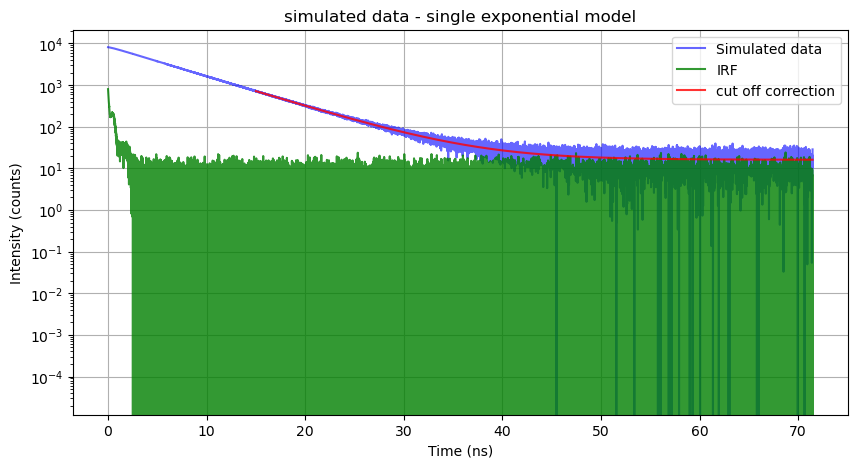

In [147]:
plt.figure(figsize=(10,5))
plt.semilogy(t_adjusted, simulated_data_truncated, 'b', label = 'Simulated data', alpha=0.6)
plt.semilogy(t_adjusted, IRF_noisy_truncated, 'g', label = 'IRF', alpha=0.8)
plt.semilogy(t_new_2, cut_of_correction_data_fit, 'r', label = 'cut off correction', alpha=0.8)
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (counts)')
plt.title('simulated data - single exponential model')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()


In [31]:
print(len(simulated_data_truncated))

37917


5000000
[0.0000000e+00 4.0000000e-03 8.0000000e-03 ... 1.9999992e+04 1.9999996e+04
 2.0000000e+04]
5000000
[ 8.12369945e+03  8.10369863e+03  8.12094427e+03 ... -6.85606207e+00
 -5.76826791e+00  1.00829071e+00]


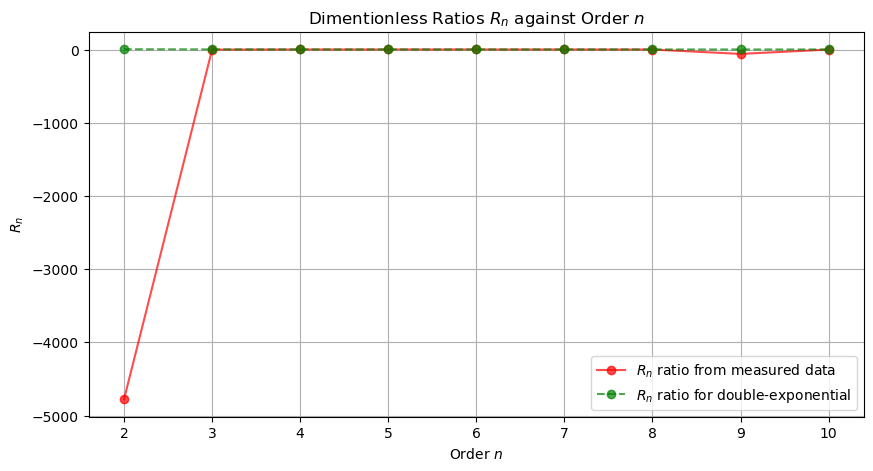

In [461]:
n_values_2 = np.arange(2, 11)

#T_large = np.linspace(0, 0.004*1000000, 1000001)

#cut_off_correction_data = cut_off_correction_parameters(t, *popt_3)

def R_n(n, data, t, delta_t_ns):
    if n >= 2:
        return (experimental_moment(n, data, t, delta_t_ns) * experimental_moment(n-2, data, t, delta_t_ns) ) / (experimental_moment(n-1, data, t, delta_t_ns)**2)
    else:
        raise ValueError("n must be larger or equal to 2")

def slice_array_from_max(arr):
    # Find the index of the maximum value
    max_index = np.argmax(arr)
    # Slice the array from the maximum index to the end
    sliced_arr = arr[max_index:]
    return sliced_arr

#first normalise the data

T_large = np.linspace((len(simulated_data_truncated)+1)*0.004, 0.004*5000000, (5000000- len(simulated_data_truncated)))

cut_off_correction_data = cut_off_correction_parameters(T_large, *popt_3) 

noise_level = 0.0008 * max(simulated_data_truncated)
noise = np.random.normal(loc=0, scale=noise_level, size=cut_off_correction_data.shape)

cut_off_data = np.array(cut_off_correction_data) + np.array(noise)

concatenated_array_time = np.concatenate((t_adjusted, T_large))

print(len(concatenated_array_time))
print(concatenated_array_time)

      
concatenated_array = np.concatenate((simulated_data_truncated, cut_off_data))

print(len(concatenated_array))
print(concatenated_array)


R_n_values = [R_n(n, concatenated_array, concatenated_array_time, delta_t) for n in n_values_2]

def R_n_sec(n):
    if n >= 2:
        return n / (n-1)
    else:
        raise ValueError("n must be larger or equal to 2")

def R_n_double(n, a1, tau1, a2, tau2):
    if n >= 2:
        return (n / (n-1)) * (((a1*(tau1**(n+1)) + (a2)*(tau2**(n+1)))*(a1*(tau1**(n-1)) + (a2)*(tau2**(n-1)))) / (a1*(tau1**(n)) + (a2)*(tau2**(n)))**2)
    else:
        raise ValueError("n must be larger or equal to 2")
        
R_n_sec_values = [R_n_sec(n) for n in n_values_2]


#theoretical value




R_n_double_values = [R_n_double(n, 0.04, 7.32, 0.96, 0.99) for n in n_values_2]


plt.figure(figsize=(10,5))
plt.plot(n_values_2, R_n_values, 'ro-', label='$R_n$ ratio from measured data', alpha=0.7)
#plt.plot(n_values_2, R_n_sec_values, 'go-', label='$R_n$ ratio for single-exponential', alpha=0.7)
#plt.plot(n_values_2, R_n_theoretical, 'bo-', label='$R_n$ ratio theoretical', alpha=0.7)
plt.plot(n_values_2, R_n_double_values, 'go--', label='$R_n$ ratio for double-exponential', alpha=0.7)
plt.xlabel('Order $n$')
plt.ylabel('$R_n$')
plt.title('Dimentionless Ratios $R_n$ against Order $n$')
plt.legend()
plt.grid(True)
plt.show()   





97861
97861
17861


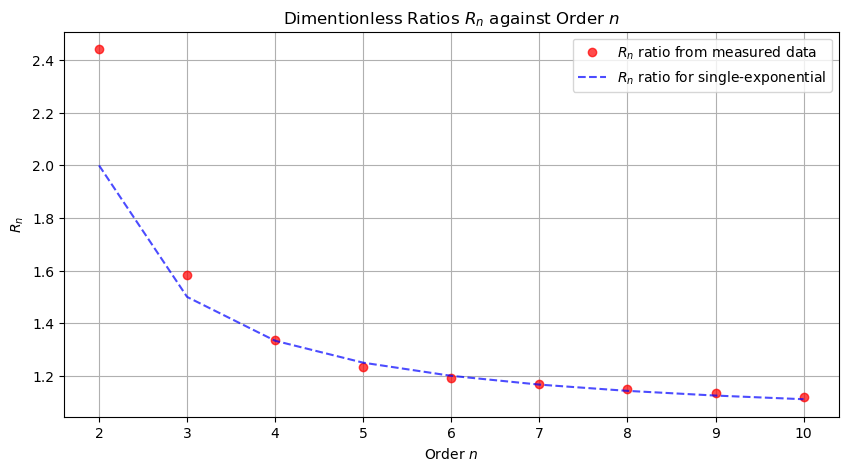

In [478]:
import numpy as np
from scipy.integrate import simps
from math import factorial
from numpy.polynomial.polynomial import Polynomial
n_values_2 = np.arange(2, 11)
def binomial_coefficient(n, k):
    # Calculate the binomial coefficient "n choose k"
    return factorial(n) // (factorial(k) * factorial(n - k))

def integrate_for_n(t, data, n):
    # Original provided function to calculate the integral for the nth power
    #background = 6.5
    #background = np.mean(-data[int(0.0001*len(data)):])
    #corrected_data = data - noise
         # Calculate the background as mean of the last 10% of the data points
    #n_background = round(len(data) * 0.4)
    #background = np.mean(data[-n_background:])
    fit_region = data[-int(0.40*len(data)):]
    model = Polynomial.fit(t[-int(0.40*len(t)):], fit_region, deg=2)
    background_fit = model(t)
    corrected_data = data - background_fit 
    integrand_num = (t**n) * corrected_data
    integrand_dem = corrected_data
    integral_num = simps(integrand_num, t)
    integral_dem = simps(integrand_dem, t)
    return integral_num / integral_dem


def calculate_tn(t, data_m, data_n, max_n):
    # Calculate all <t^n> up to the max_n
    tn_values = [0] * (max_n + 1)  # Initialize a list to hold <t^n> values
    tn_values[0] = integrate_for_n(t, data_m, 0) / integrate_for_n(t, data_n, 0)  # Calculate <t^0>

    # Calculate each <t^n> value iteratively
    for n in range(1, max_n + 1):
        M_n = integrate_for_n(t, data_m, n)  # Calculate M_n using data_m
        N_0 = integrate_for_n(t, data_n, 0)  # N_0 is the same for all n, calculated from data_n
        sum_binomial = sum(binomial_coefficient(n, i) * integrate_for_n(t, data_n, i) * tn_values[n - i] for i in range(1, n + 1))
        tn_values[n] = (M_n - sum_binomial) / N_0  # Calculate <t^n>
    
    return tn_values[max_n]  # Return <t^max_n>



def R_n_newer(t, data_m, data_n, max_n):
    if max_n >= 2:
        return (calculate_tn(t, data_m, data_n, max_n) * calculate_tn(t, data_m, data_n, (max_n - 2)))/ (calculate_tn(t, data_m, data_n, (max_n-1))**2)
    else:
        raise ValueError("n must be larger or equal to 2")


   

R_n_values = [R_n_newer(t_adjusted, simulated_data_truncated, IRF_noisy_truncated, n) for n in n_values_2]

t_new = np.linspace(0, 0.004*100000, 100001)

t_adjusted_new, theoretical_data, theoretical_irf = single_exp_model_truncated(t_new, *model_params)

print(len(t_adjusted_new))
print(len(theoretical_data))
print(len(theoretical_irf))



def R_n_sec(n):
    if n >= 2:
        return n / (n-1)
    else:
        raise ValueError("n must be larger or equal to 2")



R_n_double_values = [R_n_double(n, 0.04, 7.32, 0.96, 0.99) for n in n_values_2]
R_n_sec_values = [R_n_sec(n) for n in n_values_2]

plt.figure(figsize=(10,5))
plt.plot(n_values_2, R_n_values, 'ro', label='$R_n$ ratio from measured data', alpha=0.7)
plt.plot(n_values_2, R_n_sec_values, 'b--', label='$R_n$ ratio for single-exponential', alpha=0.7)
#plt.plot(n_values_2, R_n_theoretical, 'bo-', label='$R_n$ ratio theoretical', alpha=0.7)
#plt.plot(n_values_2, R_n_double_values, 'go--', label='$R_n$ ratio for double-exponential', alpha=0.7)
plt.xlabel('Order $n$')
plt.ylabel('$R_n$')
plt.title('Dimentionless Ratios $R_n$ against Order $n$')
plt.legend()
plt.grid(True)
plt.show()   






C:\Users\arune


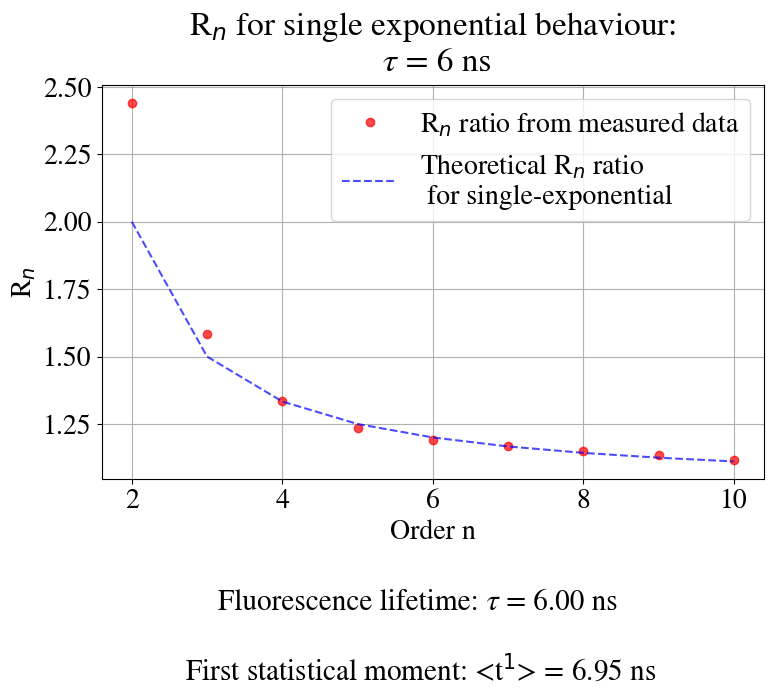

In [505]:

import os
print(os.getcwd())

plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 20


plt.figure(figsize=(8,7))
plt.plot(n_values_2, R_n_values, 'ro', label='R$_n$ ratio from measured data', alpha=0.7)
plt.plot(n_values_2, R_n_sec_values, 'b--', label='Theoretical R$_n$ ratio \n for single-exponential', alpha=0.7)
#plt.plot(n_values_2, R_n_theoretical, 'bo-', label='$R_n$ ratio theoretical', alpha=0.7)
#plt.plot(n_values_2, R_n_double_values, 'go--', label='$R_n$ ratio for double-exponential', alpha=0.7)
plt.xlabel('Order n')
plt.ylabel('R$_n$')
plt.title('R$_n$ for single exponential behaviour:\n 𝜏 = 6 ns', pad=10)
plt.legend()
plt.grid(True)
# Use tight layou

# Adding normal text below the plot
plt.figtext(0.53, -0.0001, "Fluorescence lifetime: 𝜏 = 6.00 ns\n \n First statistical moment: <t$^1$> = 6.95 ns ", 
            ha="center", fontsize=21)

# Use tight layout
plt.tight_layout(rect=[0, 0.15, 1, 1])  # Adjust the rectangle to leave space at the bottom for the text

# Save and show plot
plt.savefig('single_6ns_moments.png', dpi=600, bbox_inches='tight')
plt.show()




In [479]:
print(calculate_tn(t_adjusted, simulated_data_truncated, IRF_noisy_truncated, 1))

6.945109351596676
